# **Deep Learning (Model Handcrafted)** <br/>
**Master's  Degree Program in Data Science and Advanced Analytics, with a specialization in Data Science (A.Y. 2022/2023)**<br/>
**NOVA IMS**<br/>

## Group Members
```
20220604 - Adriana Monteiro - 20220604@novaims.unl.pt
20170746 - Inês Nascimento - r20170746@novaims.unl.pt
20220640 - Janaina Santos - 20220640@novaims.unl.pt
20221396 - Stanislav Slesarev - 20221396@novaims.unl.pt
20220609 - Samuel Santos - 20220609@novaims.unl.pt
```
## Data Source link:
https://drive.google.com/drive/folders/1MQihgKcmoiZS0BUjL9kwigmhKmgt8PHJ?usp=share_link

## Summary

In this notebook, we develop several predictive models based on convolutional neural network (CNN) and its different approaches mainly based on what we have learned in classes.

In the final step, the test prediction was performed on the model with best results on validation and train when considering accuracy, recall and precision.

## References

1. Class Weights, [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html);
2. Data Augmentation, [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator);
3. Data Loading, [Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory);
4. TensorFlow, [Documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols);
5. Evaluation Metrics for Medical Applications, [Source](https://www.medrxiv.org/content/10.1101/2021.04.07.21254975v1.full)
6. Adam optimizer documentation
[Source](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

## 1. Notebook setup

### 1.1. Instructions

To run this Notebook, you should:

 - Add the folder (link) as a shortcut to your google drive home/root directory:
https://drive.google.com/drive/folders/1MQihgKcmoiZS0BUjL9kwigmhKmgt8PHJ?usp=share_link

### 1.2. Imports

In [ ]:
# Importing the needed libraries

import tensorflow as tf
from tensorflow.keras import datasets, Sequential, layers, initializers, regularizers, losses, optimizers, metrics
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import os
import time
import shutil
import random
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from google.colab import widgets

import tensorflow_datasets as tfds

### 1.3. Define global parameters/objects

In [ ]:
# Parameters to run the Notebook

dicParams = {}
dicClasses = {}

dicParams["seed"] = 0
dicParams['gdrive'] = True

dicParams["data_folder"] = '/content/drive/MyDrive/project/cell-cancer-data'
#dicParams["data_folder"] = 'https://drive.google.com/drive/folders/1MQihgKcmoiZS0BUjL9kwigmhKmgt8PHJ?usp=share_link'

In [ ]:
# Setup drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.4 Import Folders

Set train, validation and test folders. 

In [ ]:
# Define the train, validation, and test folder paths

train_folder = dicParams["data_folder"]  + "/train"
val_folder   = dicParams["data_folder"]  + "/val"
test_folder  = dicParams["data_folder"]  + "/test"

### 1.5 Define functions that'll be used in the Notebook

#### 1.5.1 Function show_sample_batch(ds, grid_size=(3, 3))


This function shows some images form a dataset, organized in a rectangular grid.

In [1]:
# To invoque: show_sample_batch(ds_train)

def show_sample_batch(ds, grid_size=(3, 3)):
  '''
  # def show_sample_batch(ds, grid_size=(3, 3)):
  # To invoque: show_sample_batch(ds_train)
  '''
  if gShowImages:
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")


#### 1.5.2 Function plot_confusion_matrix

Given actual and predicted labels, for train and validation, this function presents the confusion matrices for both datasets, decorated with the list of labels provided.

In [2]:
# Function to plot confusion matrices 

def plot_confusion_matrix(train_actual, train_predicted, val_actual, val_predicted, labels):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot confusion matrix for training data
    train_cm = tf.math.confusion_matrix(train_actual, train_predicted)
    train_ax = sns.heatmap(train_cm, annot=True, fmt='g', ax=axes[0])
    train_ax.set_title('Training Confusion Matrix')
    train_ax.set_xlabel('Predicted Action')
    train_ax.set_ylabel('Actual Action')
    train_ax.set_xticklabels(labels, rotation=90)
    train_ax.set_yticklabels(labels, rotation=0)

    # Plot confusion matrix for validation data
    val_cm = tf.math.confusion_matrix(val_actual, val_predicted)
    val_ax = sns.heatmap(val_cm, annot=True, fmt='g', ax=axes[1])
    val_ax.set_title('Validation Confusion Matrix')
    val_ax.set_xlabel('Predicted Action')
    val_ax.set_ylabel('Actual Action')
    val_ax.set_xticklabels(labels, rotation=90)
    val_ax.set_yticklabels(labels, rotation=0)

    plt.tight_layout()
    plt.show()



#### 1.5.3 Preprocessing Function

Used to load datasets, as described in the preprocessing notebook

In [3]:
# Function to preprocess the images dataset

def preprocessing(data_folder, seed=42, train=True,
                  image_size=(96, 128),
                  crop_to_aspect_ratio=True,
                  color_mode='rgb',
                  batch_size=64,
                  labels='inferred',
                  label_mode='categorical',
                  class_names=['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B'],
                  shuffle=True,
                  weight=False,
                  augmentation=False):

    ds_folder = image_dataset_from_directory(data_folder,
                                              image_size=image_size,
                                              crop_to_aspect_ratio=crop_to_aspect_ratio if train else False,
                                              color_mode=color_mode,
                                              batch_size=batch_size,
                                              labels=labels,
                                              label_mode=label_mode,
                                              class_names=class_names,
                                              shuffle=shuffle,
                                              seed=seed)

    # Calculate class weights
    class_weight_dict = None
    if train and weight:
        y_train_labels = np.concatenate([y for x, y in ds_folder], axis=0)
        y_train_indices = np.argmax(y_train_labels, axis=1)
        unique_classes = np.unique(y_train_indices)
        class_weights = class_weight.compute_class_weight('balanced', classes=unique_classes, y=y_train_indices)
        class_weight_dict = dict(zip(unique_classes, class_weights))
        print("Class weights:", class_weight_dict)

    # Data augmentation 
    datagen = None
    ds_train_augmented = None
    if train and augmentation:
        datagen = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

        ds_train_augmented = datagen.flow_from_directory(data_folder,
                                                         target_size=image_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=True,
                                                         seed=seed,
                                                         classes=class_names)
        ds_folder = ds_train_augmented

    #Creating an iterator object for ds_train
    input_shape = None
    if train:
      iter_train = iter(ds_folder)
      batch_x_train, batch_y_train = iter_train.next()
      input_shape = (batch_x_train.shape)

    print("\nObject's type:\t", type(ds_folder))
    print("Is it a tf.data.Dataset?\t R:", isinstance(ds_folder, tf.data.Dataset))

    return ds_folder, class_weight_dict, input_shape

#### 1.5.4 Model Evaluation Function

Function to do the compilation and evaluation of the model with the option of data augmentation with the defined hyperparameters.

Steps involved:

- Instanciate the model
- Compile
- Train
- Print metrics
- Plot confusion matrices for train/validation

In [4]:

# Function to do the compilation and evaluation of the model with the option of data augmentation with the defined hyperparameters

def modeleval(name, model=None, hyperparameters=None, ds_train=None, ds_val=None, input_shape=None, train=True, verbose=1, printPlot=False, printConfMatrix=False, class_weight_dict=None):
    
    global model_log
    model_log = []

    if model is not None:
        # Builds the DAG 
        model.build(input_shape)

        # Check the network
        model.summary()

        if train:
            # Measure the start time
            start = time.time()

            learning_rate = hyperparameters["learning_rate"]

            # Choose the optimizer based on the condition
            optimizer = optimizers.Adam(learning_rate=learning_rate) if hyperparameters["optimizer"] == "adam" else optimizers.SGD(learning_rate=learning_rate)

            # Compile the model with the chosen optimizer
            model.compile(loss=losses.CategoricalCrossentropy(),
                          optimizer=optimizer,
                          metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                                   metrics.AUC(name='AUROC', multi_label=True),
                                   metrics.Recall(name='recall', class_id=0),
                                   metrics.Precision(name='precision')])

            epochs = hyperparameters["epochs"]

            # Add the EarlyStopping callback if early_stopping_patience is defined
            callbacks = []
            if hyperparameters["early_stopping_patience"] is not None:
                early_stopping = EarlyStopping(monitor='val_loss', patience=hyperparameters["early_stopping_patience"], restore_best_weights=True)
                callbacks.append(early_stopping)

            # Pass the class_weight_dict parameter to the fit method if provided
            history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=verbose, callbacks=callbacks, class_weight=class_weight_dict if class_weight_dict is not None else None)

            # Measure the end time
            print("Training time: {:.4f}s".format(time.time() - start))

        # Plot learning curves
        if printPlot:
            df_hist = pd.DataFrame.from_dict(history.history)
            df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
            secondary_y = ["accuracy", "val_accuracy"]
            ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                              secondary_y=secondary_y,
                              kind="line", figsize=(6, 3), grid=True, legend=True,
                              ylabel="Categorical cross-entropy",
                              xlabel="Epoch", title="Learning curves",
                              style=[".--", ".-"] * 3,
                              color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"],
                              alpha=0.75, fontsize=10)
            ax.right_ax.set_ylabel("Accuracy")
            ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
            ax.right_ax.set_ylim(0.45, 1.05)
            ax.legend(loc=(1.15, 0.40), framealpha=1.0)
            plt.show()

        if printConfMatrix:
            predictions_train = np.array([])
            labels_train = np.array([])
            for x, y in ds_train:
                labels_train = np.concatenate([labels_train, np.argmax(y, axis=-1)])
                predictions_train = np.concatenate([predictions_train, np.argmax(model.predict(x,verbose=0), axis=-1)])

            predictions_val = np.array([])
            labels_val = np.array([])
            for x, y in ds_val:
                labels_val = np.concatenate([labels_val, np.argmax(y, axis=-1)])
                predictions_val = np.concatenate([predictions_val, np.argmax(model.predict(x,verbose=0), axis=-1)])
                  
            plot_confusion_matrix(labels_train, predictions_train, labels_val, predictions_val, hyperparameters["class_names"])

        model_log.append([name, hyperparameters, history])

    return model

### 1.6 Define Model's Parameters

In [ ]:
# Model parameters

dicModelParams = {}
dicModelParams["image_size"] = (192,256)
dicModelParams["crop_to_aspect_ratio"] = True
dicModelParams["color_mode"] = 'rgb'
dicModelParams["batch_size"] = 64
dicModelParams["labels"] = 'inferred'
dicModelParams["label_mode"] = 'categorical'
dicModelParams["class_names"] = ['Benign', '[Malignant] Pre-B','[Malignant] Pro-B', '[Malignant] early Pre-B']
dicModelParams["shuffle"] = True
dicModelParams["seed"] = dicParams["seed"]
dicModelParams["interpolation"] = 'bilinear'        
dicModelParams["optimizer"] = None        
dicModelParams["learning_rate"] = 0.001
dicModelParams["epochs"] = 30
dicModelParams["early_stopping_patience"] = 5

### 1.7 Creating dataset instances - Original and Preprocessed

Load datasets to use in the models below

In [ ]:

ds_train, _ , input_shape = preprocessing(train_folder, train=True, seed=dicModelParams["seed"]) #original
ds_train_prep, class_weight_dict_prep, input_shape_prep = preprocessing(train_folder, train=True, seed=dicModelParams["seed"], weight = True, augmentation = True) #preprocessed
ds_val, _ , _ = preprocessing(val_folder,train=False, seed=dicModelParams["seed"]) #validation
ds_test, _ , _ = preprocessing(test_folder,train=False, seed=dicModelParams["seed"]) # test

Found 2558 files belonging to 4 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Found 2558 files belonging to 4 classes.
Class weights: {0: 1.5635696821515892, 1: 0.8370418848167539, 2: 1.0622923588039868, 3: 0.8167305236270753}
Found 2558 images belonging to 4 classes.

Object's type:	 <class 'keras.preprocessing.image.DirectoryIterator'>
Is it a tf.data.Dataset?	 R: False
Found 316 files belonging to 4 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Found 328 files belonging to 4 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True


## 2. Base Model - `CustomResNet - CNN4`

### 2.1 BottleneckBlock

In this section, there is a convolutional neural network (CNN) with several convolutional, activation, and normalization layers, as well as downsampling.

In [ ]:
# Create a blueprint for a Bottleneck Block

class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x


### 2.2 CustomResNet

In the cell bellow, we defined the convolutional layers, batch normalization layers, a dense classifier, non-learnable layers, among others.

In [ ]:
# Define the convolutional layers, batch normalization layers, a dense classifier, non-learnable layers, etc.

class CustomResNet(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # # Z-scores 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=dicParams['seed'])        
        self.conv3 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=dicParams['seed'])   
        # etc.
        # Classifier
        self.dense4 = layers.Dense(units=4, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.dense4(x)
        return x


# Create an instance of CustomCNN
cnn4 = CustomResNet(seed=dicParams['seed'])

### 2.3 CNN4 - Model Evaluation

We instanciate the model using the modeleval function described below

Model: "custom_res_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  multiple                 12        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           multiple                  9472      
                                                                 
 batch_normalization_9 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 bottleneck_block_2 (Bottlen  multiple                 58752     
 eckBlock)                                                       
                                                                 
 bottleneck_block_3 (Bottlen  multiple                 96384     
 eckBlock)                                        

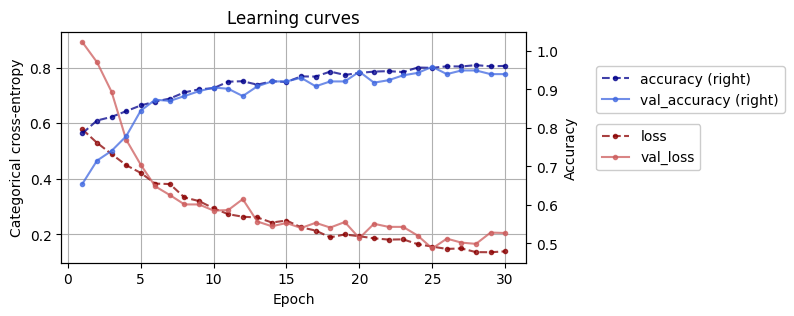

In [ ]:
customcnn4 = modeleval('base model', model=cnn4, hyperparameters=dicModelParams, ds_train=ds_train_prep, ds_val=ds_val, input_shape=input_shape_prep, class_weight_dict=class_weight_dict_prep, printPlot=True, printConfMatrix=False)

In [ ]:
model_log

[['base model',
  {'image_size': (192, 256),
   'crop_to_aspect_ratio': True,
   'color_mode': 'rgb',
   'batch_size': 64,
   'labels': 'inferred',
   'label_mode': 'categorical',
   'class_names': ['Benign',
    '[Malignant] Pre-B',
    '[Malignant] Pro-B',
    '[Malignant] early Pre-B'],
   'shuffle': True,
   'seed': 0,
   'interpolation': 'bilinear',
   'optimizer': None,
   'learning_rate': 0.001,
   'epochs': 30},
 ['base model',
  {'image_size': (192, 256),
   'crop_to_aspect_ratio': True,
   'color_mode': 'rgb',
   'batch_size': 64,
   'labels': 'inferred',
   'label_mode': 'categorical',
   'class_names': ['Benign',
    '[Malignant] Pre-B',
    '[Malignant] Pro-B',
    '[Malignant] early Pre-B'],
   'shuffle': True,
   'seed': 0,
   'interpolation': 'bilinear',
   'optimizer': None,
   'learning_rate': 0.001,
   'epochs': 30},

The model was trained for 30 epochs, and the training results are promising, with the accuracy improving over time. The model achieved an accuracy of 0.9597 on the validation set, with an AUROC of 0.9944. The model achieved high recall and precision rates across most epochs, indicating good performance.

## 3. Second model - `CustomResNet Dropout`

### 3.1 CustomResNet Dropout - Function

Now, the CustomResNet model is with dropout regularization having preprocessing, convolutional layers, residual bottleneck blocks and a final classifier.

In [ ]:
# This CustomResNet model is with droupout 

class CustomResNet_dropout(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # # Z-scores 
        self.preprocess = layers.BatchNormalization()
        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()   
        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=dicParams['seed'])        
        self.conv3 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=dicParams['seed'])   
        # etc.
        self.drop = layers.Dropout(rate=0.2)
        # Classifier
        self.dense4 = layers.Dense(units=4, activation="softmax", 
                                   kernel_initializer=initializers.GlorotNormal(seed=dicParams['seed']))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        # Head of the network 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool3x3(x)
        # Residual blocks
        x = self.conv2(x)
        x = self.conv3(x)
        # Classifier
        x = self.gmp(x)
        x = self.drop(x)
        x = self.dense4(x)
        return x


# Create an instance of CustomCNN
cnn_dropout = CustomResNet_dropout(seed=dicParams['seed'])

### 3.2 CustomResNet Dropout - Model Evaluation

Model: "custom_res_net_dropout_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_43 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_46 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_44 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_8 (Bottlen  multiple                 58752     
 eckBlock)                                                       
                                                                 
 bottleneck_block_9 (Bottlen  multiple                 96384     
 eckBlock)                                

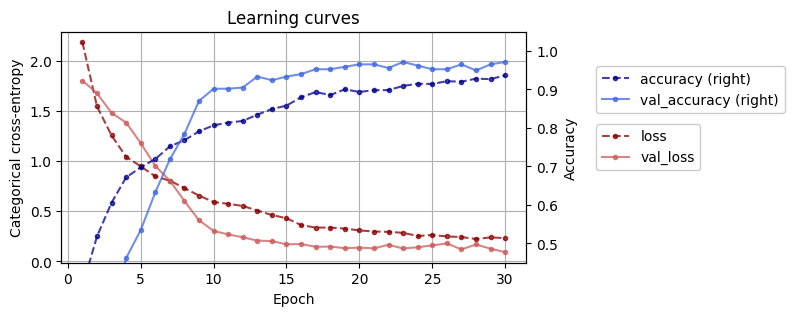

In [ ]:
customcnn4_dropout = modeleval('base model dropout', model=cnn_dropout, hyperparameters=dicModelParams, ds_train=ds_train_prep, ds_val=ds_val, input_shape=input_shape_prep, class_weight_dict=class_weight_dict_prep, printPlot=True, printConfMatrix=False)

In [ ]:
model_log

[['base model dropout',
  {'image_size': (192, 256),
   'crop_to_aspect_ratio': True,
   'color_mode': 'rgb',
   'batch_size': 64,
   'labels': 'inferred',
   'label_mode': 'categorical',
   'class_names': ['Benign',
    '[Malignant] Pre-B',
    '[Malignant] Pro-B',
    '[Malignant] early Pre-B'],
   'shuffle': True,
   'seed': 0,
   'interpolation': 'bilinear',
   'learning_rate': 0.001,
   'epochs': 10},

The results show that the model was able to achieve high accuracy, AUROC, recall, and precision on both the training and validation sets. The model was able to achieve an accuracy of 92.14%, AUROC of 98.68%, recall of 85.57%, and precision of 92.87% on the validation set.

Overall, the model seems to be performing well and has a good balance between accuracy and generalization. 

## 4. Third Model - `CustomResNet Dropout with Adam Optimizer`

### 4.1 CustomResNet Dropout with Adam Optimizer - Model Evaluation - Preprocessed Dataset

Model: "custom_res_net_dropout_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_11 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_2 (Bottlen  multiple                 58752     
 eckBlock)                                                       
                                                                 
 bottleneck_block_3 (Bottlen  multiple                 96384     
 eckBlock)                                

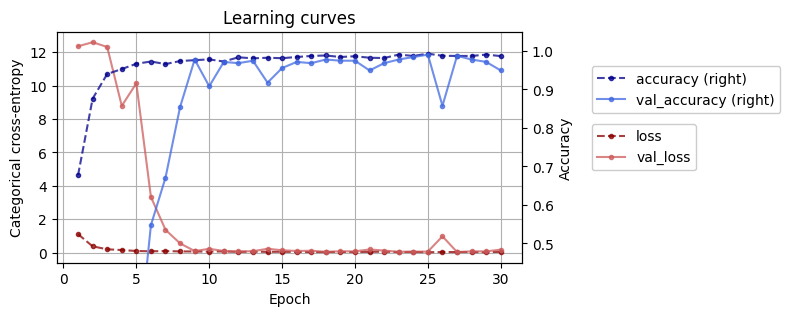

In [ ]:
dicModelParams["optimizer"] = "adam"  

customcnn4_dropout_adam = modeleval('base model dropout adam', model=cnn_dropout, hyperparameters=dicModelParams, ds_train=ds_train_prep, ds_val=ds_val, input_shape=input_shape_prep, class_weight_dict=class_weight_dict_prep, printPlot=True, printConfMatrix=False)
model_log

dicModelParams["optimizer"] = None     


The Adam Optmizer performed a consistent increase on model performance.

When considering the results up to epoch 25, with the best results. The performance metrics show that the model has a high accuracy (99.3%) and a low loss (0.0254) on the training set. Similarly, it has a high accuracy (98.6%) and low loss (0.0450) on the validation set. Also the validation recall and validation precision have high values.

These results indicate that the model trained at epoch 25 has learned the patterns within the training data well and is also able to generalize well to new data.




### 4.2 CustomResNet Dropout with Adam Optimizer - Model Evaluation - Original Dataset

Model: "custom_res_net_dropout_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_11 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_2 (Bottlen  multiple                 58752     
 eckBlock)                                                       
                                                                 
 bottleneck_block_3 (Bottlen  multiple                 96384     
 eckBlock)                                

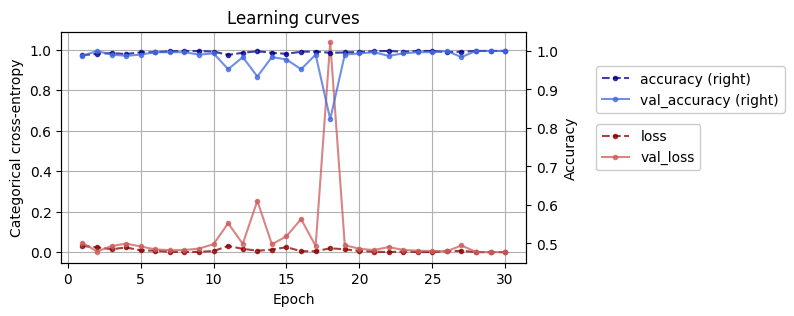

In [ ]:
dicModelParams["optimizer"] = "adam"  

customcnn4_dropout_adam_orig = modeleval('base model dropout adam', model=cnn_dropout, hyperparameters=dicModelParams, ds_train=ds_train, ds_val=ds_val, input_shape=input_shape, class_weight_dict=None, printPlot=True, printConfMatrix=False)
model_log

dicModelParams["optimizer"] = None 

With Original Data ResNet model with dropout and Adam optimizer exhibits exceptional performance on both the training and validation sets, achieving 100% accuracy on the validation set at epoch 26. This accomplishment, along with an AUROC of 1.0000, a recall of 1.0000, and a precision of 1.0000, indicates the model's potential to generalize well to unseen data. The training accuracy also consistently improves, reaching 100% by epoch 22 and maintaining this level through epoch 30, which demonstrates effective learning from the training data.

Although there fluctuations in validation accuracy, loss, and other metrics across the epochs, the overall trend of these metrics is improvement. The validation loss decreases from epoch 1, reaching its lowest point at epoch 26 with a value of 0.0051, suggesting good generalization to the validation set. 

This was considered the best model on train/validation evaluation. The next step is to perform it on test dataset.

## 5. Fourth model - `VGG - V1`

### 5.1 - VGG1 - Functions

In [ ]:
def block_vgg(conv_layers, filters, conv1x1=True, batch_norm=True, seed=0):
    block = Sequential()
    for l in range(conv_layers + conv1x1):
        block.add(layers.Conv2D(filters, 
                                kernel_size=1 if l==conv_layers else 3, padding="same",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)))
        if batch_norm:
            block.add(layers.BatchNormalization())                         
        block.add(layers.Activation("relu"))
    
    block.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return block


def encoder(input_shape, vgg_blocks1, seed=None):
    # Create CNN
    vgg1 = models.Sequential(layers.BatchNormalization(name="batch_norm_input"), name="VGG-V1")
    # Add the convolutional backbone for learning representations 
    for i, (conv_layers, filters, conv1x1) in enumerate(vgg_blocks1):
        vgg1.add(block_vgg(conv_layers, filters, conv1x1, f"block{i+1}", seed=seed))
    # Define the classification head
    vgg1.add(layers.GlobalMaxPooling2D(name="global_max_pooling"))
    vgg1.add(layers.Dropout(0.2, name="dropout"))
    vgg1.add(layers.Dense(units=4, activation="softmax",
                          kernel_initializer=initializers.GlorotNormal(seed=seed),
                          name="output_layer"))

    # Build the DAG 
    vgg1.build(input_shape)
    # Check model
    vgg1.summary()
    return vgg1

def vgg1(seed=None):

    # Define the architecture's blueprint 
    vgg_blocks1 = ((2, 32, False), (2, 64, False), (2, 128, True)) 

    # Create CNN
    vgg1 = Sequential(layers.BatchNormalization(), name="VGG-V1")
    
    # Add the convolutional backbone for learning representations
    for conv_layers, filters, conv1x1 in vgg_blocks1:
        vgg1.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
             
    # Define the classification head
    vgg1.add(layers.GlobalMaxPooling2D())
    vgg1.add(layers.Dropout(0.2))
    vgg1.add(layers.Dense(units=4, activation="softmax",
                          kernel_initializer=initializers.GlorotNormal(seed=seed)))
    
    return vgg1

vgg1 = vgg1(seed=dicParams['seed'])
    

### 5.2 Model *Evaluation*

Model: "VGG-V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_18 (Bat  (64, 96, 128, 3)         12        
 chNormalization)                                                
                                                                 
 sequential (Sequential)     (64, 48, 64, 32)          10400     
                                                                 
 sequential_1 (Sequential)   (64, 24, 32, 64)          55936     
                                                                 
 sequential_2 (Sequential)   (64, 12, 16, 128)         239488    
                                                                 
 global_max_pooling2d_2 (Glo  (64, 128)                0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (64, 128)                 0    

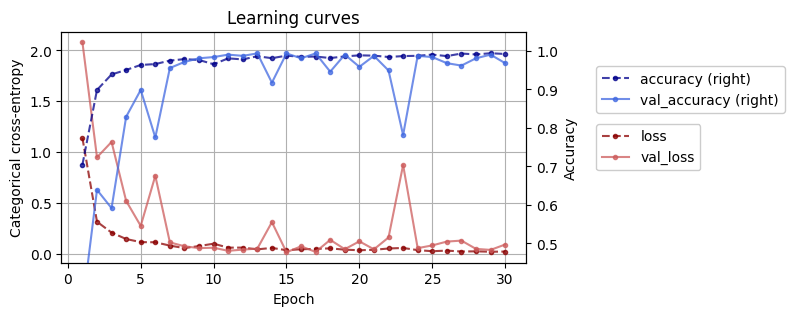

[['vgg1',
  {'image_size': (192, 256),
   'crop_to_aspect_ratio': True,
   'color_mode': 'rgb',
   'batch_size': 64,
   'labels': 'inferred',
   'label_mode': 'categorical',
   'class_names': ['Benign',
    '[Malignant] Pre-B',
    '[Malignant] Pro-B',
    '[Malignant] early Pre-B'],
   'shuffle': True,
   'seed': 0,
   'interpolation': 'bilinear',
   'optimizer': None,
   'learning_rate': 0.001,
   'epochs': 30,
   'early_stopping_patience': None},

In [ ]:
dicModelParams["optimizer"] = "adam"      
customvgg3 = modeleval('vgg1', model=vgg1, hyperparameters=dicModelParams, ds_train=ds_train_prep, ds_val=ds_val, input_shape=input_shape_prep, class_weight_dict=class_weight_dict_prep, printPlot=True, printConfMatrix=False)
dicModelParams["optimizer"] = None     
model_log

During training, the model achieved an accuracy of 99.34% on the training set and 96.20% on the validation set, with an AUROC of 0.9997 on the training set and 0.9966 on the validation set. The model also achieved a recall of 99.51% on the training set and 92.16% on the validation set, with a precision of 99.41% on the training set and 94.14% on the validation set.

The model's performance on the validation set improved throughout training, with the loss decreasing and the accuracy increasing over time. The model achieved its best performance after 14 epochs, with a validation accuracy of 99.37%, an AUROC of 1.0, a recall of 100%, and a precision of 99.37%. However, after this point, the model's performance on the validation set began to degrade, possibly due to overfitting

## 6. Fifth model - `VGG - V3`

### 6.1 - VGG3 - Functions

In [ ]:
def block_vgg(conv_layers, filters, conv1x1=True, batch_norm=True, seed=0):
    block = Sequential()
    for l in range(conv_layers + conv1x1):
        block.add(layers.Conv2D(filters, 
                                kernel_size=1 if l==conv_layers else 3, padding="same",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)))
        if batch_norm:
            block.add(layers.BatchNormalization())                         
        block.add(layers.Activation("relu"))
    
    block.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return block

def vgg3(seed=None):

    # Define the architecture's blueprint
    vgg_blocks3 = ((2, 32, False), (2, 64, False), (2, 128, True), (2, 256, True))
    
    # Create CNN
    vgg3 = Sequential(layers.BatchNormalization(), name="VGG-V3")
    
    # Add the convolutional backbone for learning representations
    for conv_layers, filters, conv1x1 in vgg_blocks3:
        vgg3.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
    
    # Define the classification head
    vgg3.add(layers.GlobalMaxPooling2D())
    vgg3.add(layers.Dropout(0.2))
    vgg3.add(layers.Dense(units=4, activation="softmax",
                          kernel_initializer=initializers.GlorotNormal(seed=seed)))

    return vgg3

vgg3 = vgg3(seed=dicParams['seed'])

### 6.2 VGG3 - Model Evaluation

Model: "VGG-V3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_84 (Bat  (64, 96, 128, 3)         12        
 chNormalization)                                                
                                                                 
 sequential_16 (Sequential)  (64, 48, 64, 32)          10400     
                                                                 
 sequential_17 (Sequential)  (64, 24, 32, 64)          55936     
                                                                 
 sequential_18 (Sequential)  (64, 12, 16, 128)         239488    
                                                                 
 sequential_19 (Sequential)  (64, 6, 8, 256)           954112    
                                                                 
 global_max_pooling2d_9 (Glo  (64, 256)                0         
 balMaxPooling2D)                                           

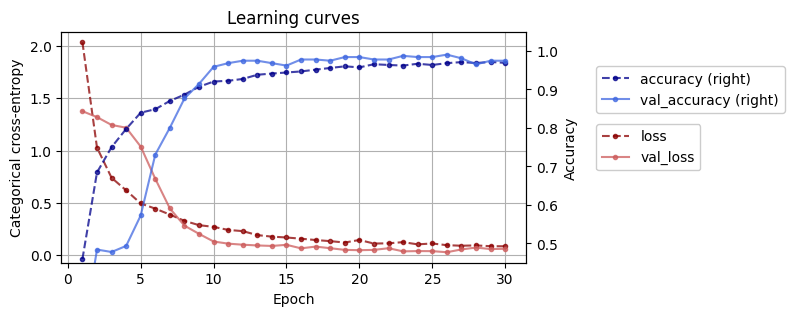

[['vgg3',
  {'image_size': (192, 256),
   'crop_to_aspect_ratio': True,
   'color_mode': 'rgb',
   'batch_size': 64,
   'labels': 'inferred',
   'label_mode': 'categorical',
   'class_names': ['Benign',
    '[Malignant] Pre-B',
    '[Malignant] Pro-B',
    '[Malignant] early Pre-B'],
   'shuffle': True,
   'seed': 0,
   'interpolation': 'bilinear',
   'optimizer': None,
   'learning_rate': 0.001,
   'epochs': 30},

In [ ]:
customvgg3 = modeleval('vgg3', model=vgg3, hyperparameters=dicModelParams, ds_train=ds_train_prep, ds_val=ds_val, input_shape=input_shape_prep, class_weight_dict=class_weight_dict_prep, printPlot=True, printConfMatrix=False)
model_log

The training process shows that the model was able to learn well from the dataset with accuracy, AUROC, recall, and precision values increasing with each epoch. The model achieved an accuracy of 97.11%, AUROC of 0.9974, recall of 0.943, and precision of 0.976 in the final epoch. The validation results also showed an improvement in each epoch, with the AUROC increasing from 0.6746 in the first epoch to 0.9999 in the final epoch. Overall, the VGG-V3 model was able to learn from the dataset and achieved high performance in both training and validation.

## 7. Test Prediction - Best Perfomance Model 

Considering the models tested in this notebook, the best performing model is the CustomResNet Dropout with Adam Optimizer using the original dataset.

The second best model was obtained through transfer learning, and is presented in the corresponding optional notebook.

### 7.1 Test Predict

In [ ]:
# Initialize empty numpy arrays to store predicted and true labels
predictions_test = np.array([])
labels_test = np.array([])

# Iterate through each sample in the test dataset
for x, y in ds_test:
  
  # Extract the true labels from the current sample and append them to the labels_test array
  true_labels = np.argmax(y, axis=-1)
  labels_test = np.concatenate([labels_test, true_labels])
  
  # Use the customcnn1 model to predict the labels for the current sample and append them to the predictions_test array
  predicted_labels = np.argmax(customcnn4_dropout_adam_orig.predict(x, verbose=0), axis=-1)
  predictions_test = np.concatenate([predictions_test, predicted_labels])

### 7.2 Confusion Matrix - Test



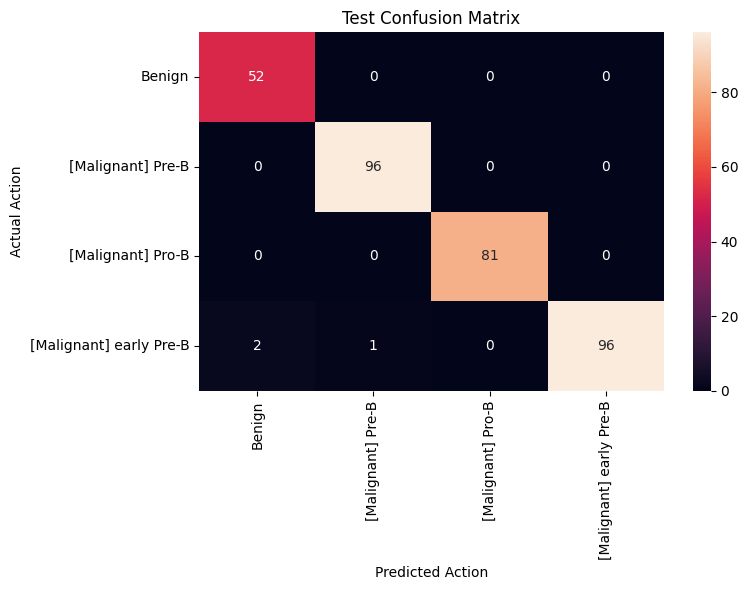

In [ ]:
# Get the class names from the dictionary of model parameters
labels = dicModelParams["class_names"]

# Create a new figure with a specified size using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))

# Plot confusion matrix for test data
val_cm = tf.math.confusion_matrix(labels_test, predictions_test)

# Create a heatmap of the confusion matrix using seaborn
val_ax = sns.heatmap(val_cm, annot=True, fmt='g', ax=ax)

# Set the plot labels
val_ax.set_title('Test Confusion Matrix')
val_ax.set_xlabel('Predicted Action')
val_ax.set_ylabel('Actual Action')
val_ax.set_xticklabels(labels, rotation=90)
val_ax.set_yticklabels(labels, rotation=0)

plt.tight_layout()
plt.show()

### 7.3 Classification Report 

In [ ]:
# Get the classification report
report = classification_report(labels_test, predictions_test, target_names=dicModelParams["class_names"])

# Print the classification report
print(report)

                         precision    recall  f1-score   support

                 Benign       0.96      1.00      0.98        52
      [Malignant] Pre-B       0.99      1.00      0.99        96
      [Malignant] Pro-B       1.00      1.00      1.00        81
[Malignant] early Pre-B       1.00      0.97      0.98        99

               accuracy                           0.99       328
              macro avg       0.99      0.99      0.99       328
           weighted avg       0.99      0.99      0.99       328



### 7.4 Test Prediction - Conclusion

The model has demonstrated high precision, recall, and F1-score for each of the different types of leukemia, including benign and [Malignant] Pre-B, [Malignant] Pro-B, and [Malignant] early Pre-B. In particular, the model has achieved very high performance on the two malignant types of leukemia ([Malignant] Pre-B and [Malignant] Pro-B), with precision and recall scores of 0.99 or higher. The model's weighted average of precision, recall, and F1-score is also high, indicating that the model has performed well across all types of leukemia, not just the majority class.